# Can you predict the strength of concrete?

## 📖 Background
You work in the civil engineering department of a major university. You are part of a project testing the strength of concrete samples. 

Concrete is the most widely used building material in the world. It is a mix of cement and water with gravel and sand. It can also include other materials like fly ash, blast furnace slag, and additives. 

The compressive strength of concrete is a function of components and age, so your team is testing different combinations of ingredients at different time intervals. 

The project leader asked you to find a simple way to estimate strength so that students can predict how a particular sample is expected to perform.

## 💾 The data
The team has already tested more than a thousand samples ([source](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength)):

#### Compressive strength data:
- "cement" - Portland cement in kg/m3
- "slag" - Blast furnace slag in kg/m3
- "fly_ash" - Fly ash in kg/m3
- "water" - Water in liters/m3
- "superplasticizer" - Superplasticizer additive in kg/m3
- "coarse_aggregate" - Coarse aggregate (gravel) in kg/m3
- "fine_aggregate" - Fine aggregate (sand) in kg/m3
- "age" - Age of the sample in days
- "strength" - Concrete compressive strength in megapascals (MPa)

***Acknowledgments**: I-Cheng Yeh, "Modeling of strength of high-performance concrete using artificial neural networks," Cement and Concrete Research, Vol. 28, No. 12, pp. 1797-1808 (1998)*.

## 💪 Challenge
Provide your project leader with a formula that estimates the compressive strength. Include:

1. The average strength of the concrete samples at 1, 7, 14, and 28 days of age.
2. The coefficients $\beta_{0}$, $\beta_{1}$ ... $\beta_{8}$, to use in the following formula:

$$ Concrete \ Strength = \beta_{0} \ + \ \beta_{1}*cement \ + \ \beta_{2}*slag \ + \ \beta_{3}*fly \ ash  \ + \ \beta_{4}*water \ + $$ 
$$ \beta_{5}*superplasticizer \ + \ \beta_{6}*coarse \ aggregate \ + \ \beta_{7}*fine \ aggregate \ + \ \beta_{8}*age $$

# Imports

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from pyod.models.iforest import IForest
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats.mstats import winsorize
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error, r2_score

sns.set_style('whitegrid')

df = pd.read_csv('data/concrete_data.csv')
df.head()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [82]:
original_shape = df.shape[0]
df = df.drop_duplicates()
print(f"Dropped {original_shape - df.shape[0]} rows.")

Dropped 25 rows.


# EDA

In [83]:
df.describe()

,cement,slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.629055,72.043134,55.535075,182.074378,6.031647,974.376468,772.686617,45.856716,35.250273
std,104.345003,86.170555,64.207448,21.340740,5.919559,77.579534,80.339851,63.734692,16.284808
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,190.680000,0.000000,0.000000,166.610000,0.000000,932.000000,724.300000,7.000000,23.523542
50%,265.000000,20.000000,0.000000,185.700000,6.100000,968.000000,780.000000,28.000000,33.798114
75%,349.000000,142.500000,118.270000,192.940000,10.000000,1031.000000,822.200000,56.000000,44.868340
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


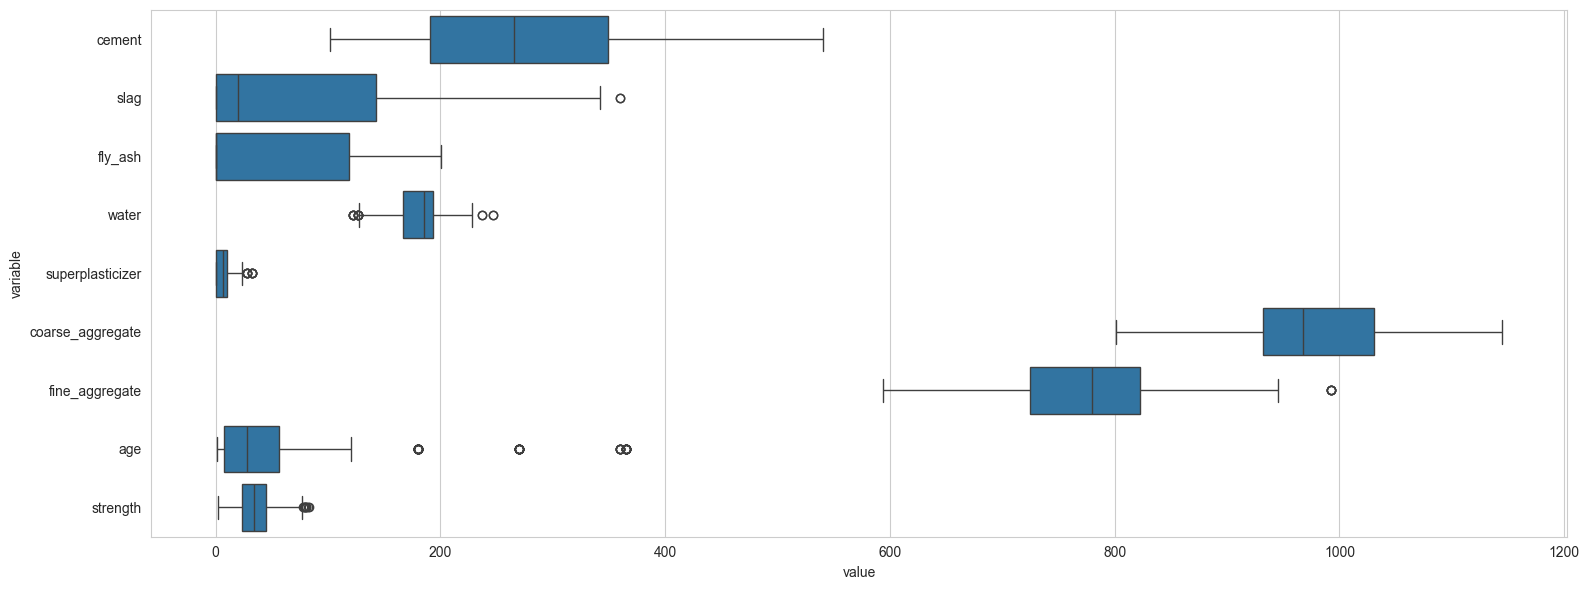

In [84]:
plt.figure(figsize = (16, 6))
sns.boxplot(data = pd.melt(df), y='variable', x = 'value')
plt.tight_layout()

## Estimate average strength of the concrete samples at 1, 7, 14, and 28 days of age.

In [85]:
indices = [1, 7, 14, 28]
sdf = df.groupby('age')['strength'].mean()
sdf = sdf[sdf.index.isin(indices)].reset_index()
sdf

,age,strength
0,1,9.452716
1,7,25.181843
2,14,28.751038
3,28,36.429421


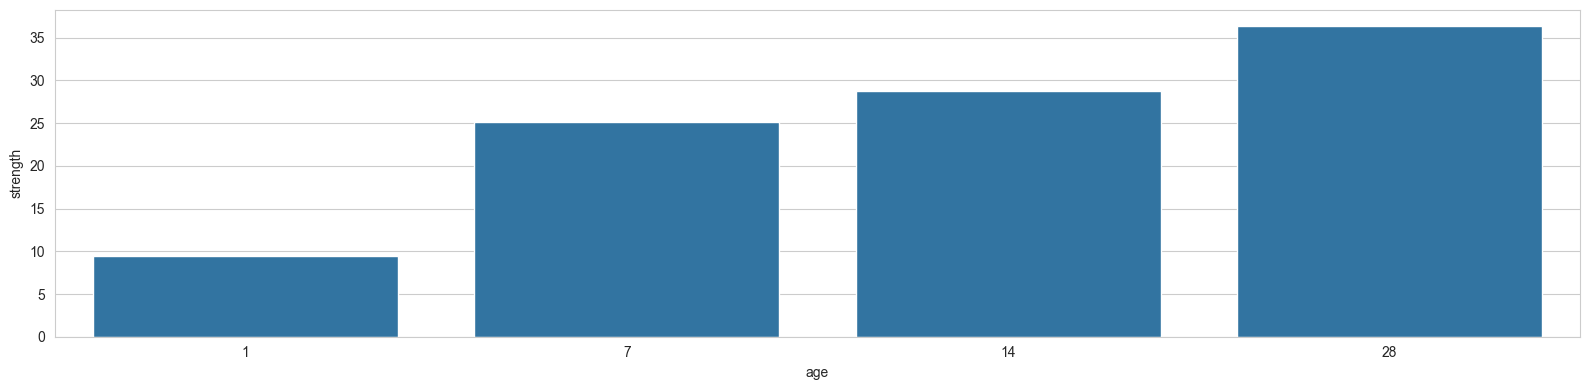

In [86]:
plt.figure(figsize = (16, 4))

sns.barplot(data = sdf, x = 'age', y = 'strength')
plt.tight_layout()

## Correlation

In [87]:
features = ['cement', 'slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age']
target = 'strength'

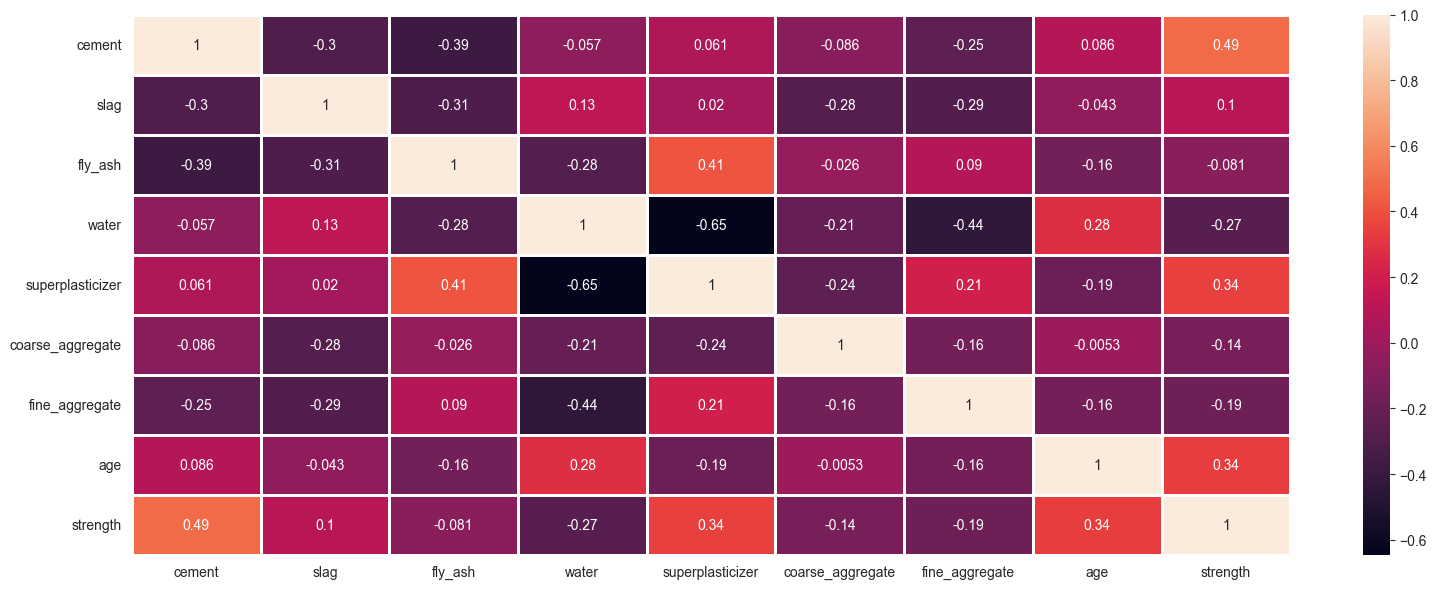

In [88]:
plt.figure(figsize = (16, 6))
sns.heatmap(df.corr(), annot = True, linewidths=2)
plt.tight_layout()

### Features vs. Target variable

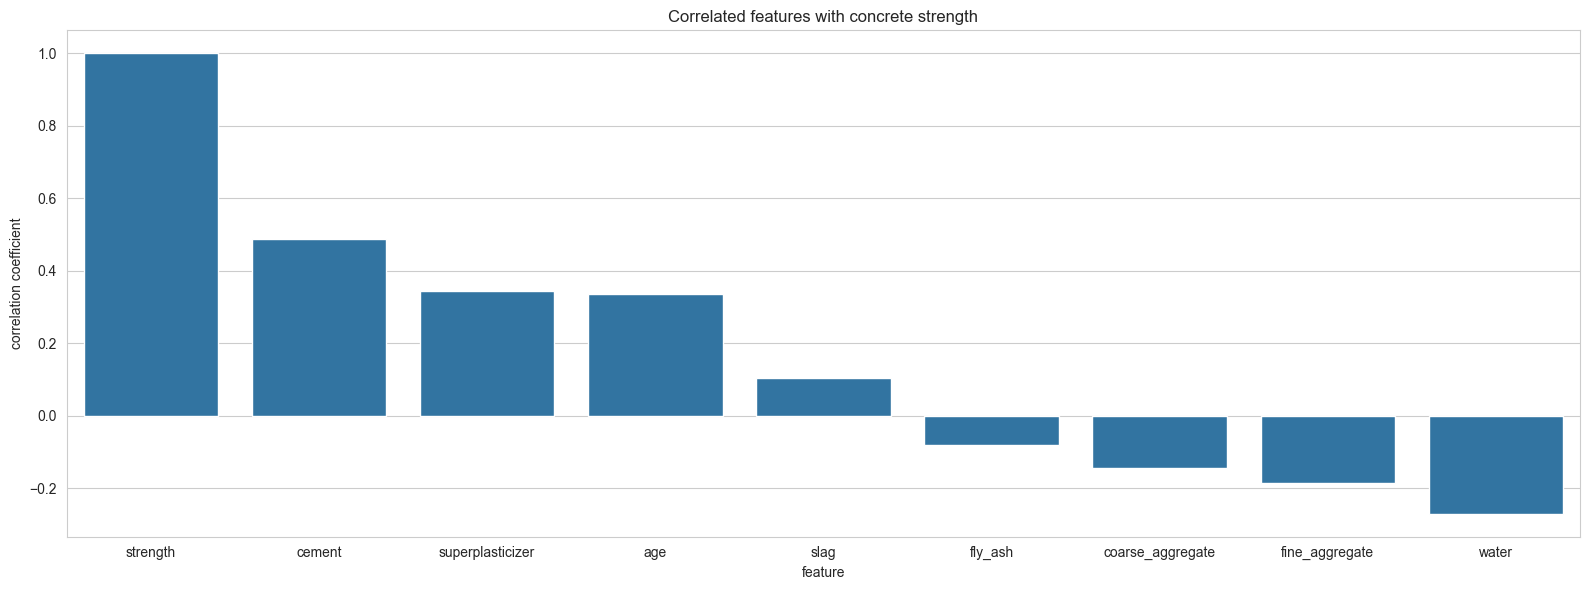

In [89]:
plt.figure(figsize = (16, 6))
corr_df = df.corr()[target].sort_values(ascending = False).reset_index()
corr_df.columns = ['feature', 'correlation coefficient']
sns.barplot(data = corr_df, x = 'feature', y = 'correlation coefficient')
plt.title("Correlated features with concrete strength")
plt.tight_layout()

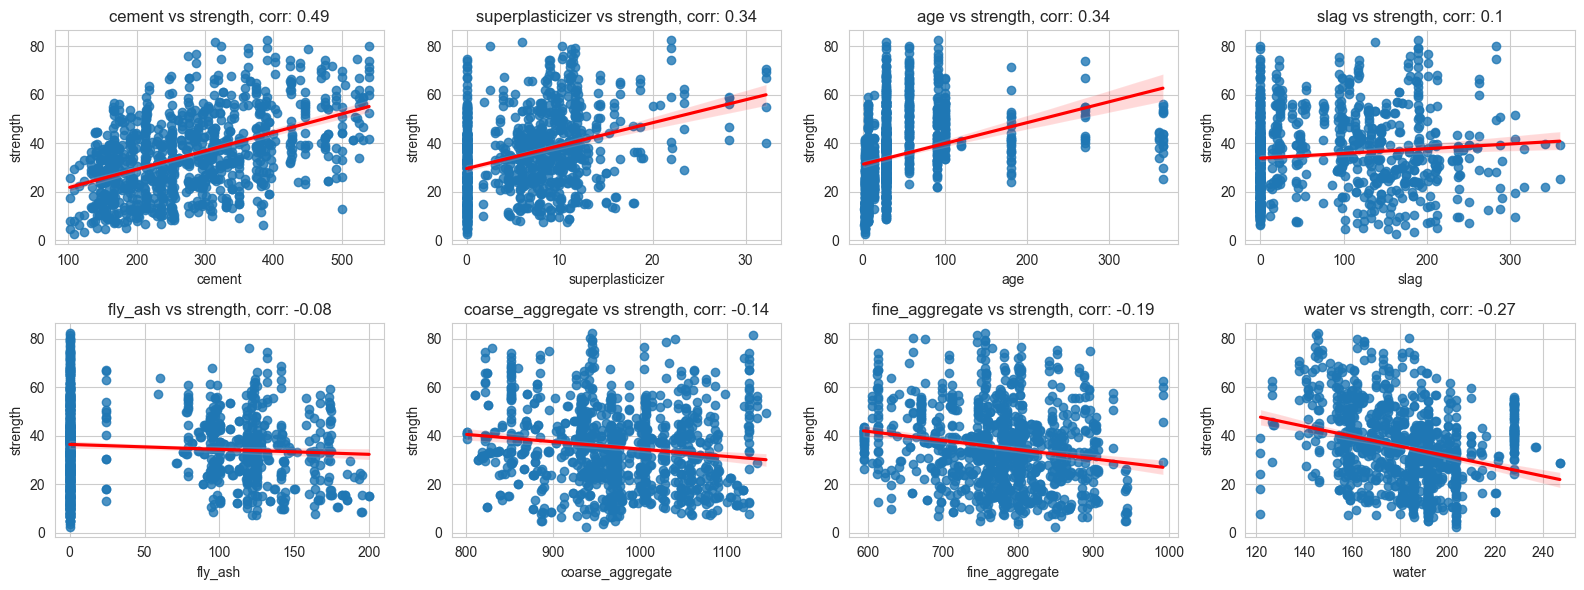

In [90]:
fig, axs = plt.subplots(2, 4, figsize = (16, 6))
axs = axs.flatten()
i = 0

feature_pairs = corr_df.values[1:]

for feature_pair in feature_pairs:
    sns.regplot(data = df, x = feature_pair[0], y = target, ax = axs[i], line_kws={'color':'red'})
    axs[i].set_title(f"{feature_pair[0]} vs {target}, corr: {round(feature_pair[1], 2)}")
    i += 1

plt.tight_layout()

### Features vs features

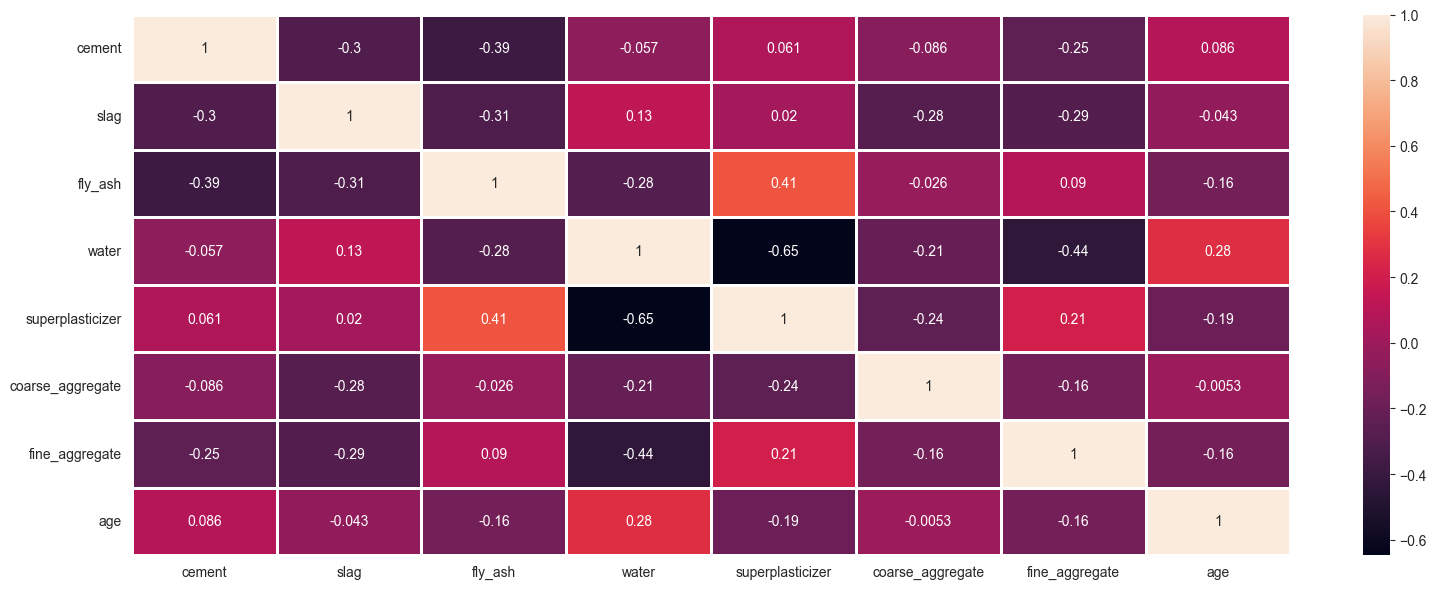

In [91]:
plt.figure(figsize = (16, 6))
sns.heatmap(df[features].corr(), annot = True, linewidths=2)
plt.tight_layout()

High correlation between water and superplasticizer; water and fine_aggregate

## Addressing Multicollinearity

In [92]:
def calculate_vif(data):
    vif_data = pd.DataFrame()
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    return vif_data

# Calculating VIF for the predictors
predictors = df.iloc[:, :-1]  # Excluding the target variable 'strength'
vif_data = calculate_vif(predictors).sort_values(by = 'VIF', ascending = False)
vif_data

,feature,VIF
5,coarse_aggregate,84.738626
3,water,81.395278
6,fine_aggregate,72.495779
0,cement,15.155077
4,superplasticizer,5.171809
2,fly_ash,4.171453
1,slag,3.261879
7,age,1.696228


A VIF value greater than 10 typically indicates significant multicollinearity that might warrant corrective measures. Here, the variables cement, water, coarse aggregate, and fine aggregate show high VIF values, suggesting strong multicollinearity. Particularly, water, coarse aggregate, and fine aggregate have very high VIF values, indicating they are highly linearly related to other variables in the model.

### Remove variables with high multicollinearity

In [93]:
reduced_predictors = predictors.drop(['coarse_aggregate', 'fine_aggregate', 'water'], axis=1)

# Recalculate VIF for the modified dataset
reduced_vif_data = calculate_vif(reduced_predictors)
reduced_vif_data.sort_values(by = 'VIF', ascending = False)

,feature,VIF
3,superplasticizer,2.898109
0,cement,2.719060
2,fly_ash,1.971800
4,age,1.545589
1,slag,1.474231


In [94]:
feature_list = reduced_vif_data['feature'].values

## Outliers

In [95]:
iforest = IForest()
labels = iforest.fit_predict(df)
outliers = df[labels == 1]
print(f"Flagged {outliers.shape[0]} outliers")

/Users/brettlill/.pyenv/versions/3.10.6/envs/lang-env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


Flagged 101 outliers


I elected to winsorize the outliers in the dataset to reduce their influence on the final regression model

In [96]:
# Winsorize the predictor variables and the target variable 'strength'
winsorized_data = df[feature_list]
winsorized_data['strength'] = df['strength']  # Including the target variable for winsorizing

# Applying winsorizing to each column
for column in winsorized_data.columns:
    winsorized_data[column] = winsorize(winsorized_data[column], limits=[0.01, 0.01])

# Show a summary of the new dataset after winsorizing
winsorized_data.describe()

/var/folders/qq/_pxy1w012md00pykw2bn68bw0000gn/T/ipykernel_79446/1548975572.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winsorized_data['strength'] = df['strength']  # Including the target variable for winsorizing
/var/folders/qq/_pxy1w012md00pykw2bn68bw0000gn/T/ipykernel_79446/1548975572.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  winsorized_data[column] = winsorize(winsorized_data[column], limits=[0.01, 0.01])
/Users/brettlill/.pyenv/versions/3.10.6/envs/lang-env/lib/python3.10/site-packag

,cement,slag,fly_ash,superplasticizer,age,strength
count,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000,1005.000000
mean,278.637512,71.690498,55.444527,5.963985,45.860697,35.231261
std,104.012756,85.170869,64.016400,5.673051,63.731950,16.153467
min,116.000000,0.000000,0.000000,0.000000,3.000000,6.883728
25%,190.680000,0.000000,0.000000,0.000000,7.000000,23.523542
50%,265.000000,20.000000,0.000000,6.100000,28.000000,33.798114
75%,349.000000,142.500000,118.270000,10.000000,56.000000,44.868340
max,531.300000,290.200000,185.300000,23.400000,365.000000,75.497622


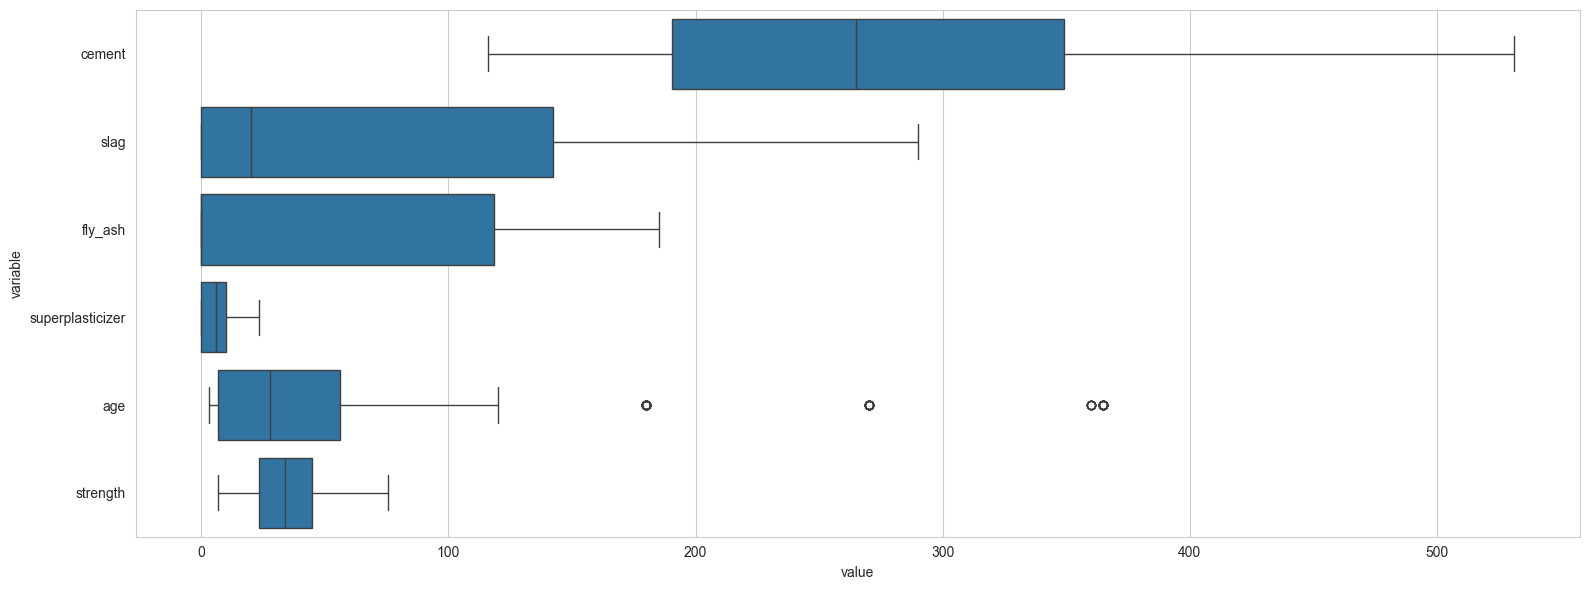

In [97]:
plt.figure(figsize = (16, 6))
sns.boxplot(data = pd.melt(winsorized_data), y='variable', x = 'value')
plt.tight_layout()

# Linear Regression Model

## Model building

In [98]:
X = winsorized_data.drop('strength', axis = 1)
#y = winsorized_data['strength']
y = np.log(winsorized_data['strength'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
X = sm.add_constant(X)
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [100]:
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     179.0
Date:                Mon, 13 May 2024   Prob (F-statistic):          1.11e-127
Time:                        12:33:06   Log-Likelihood:                -324.45
No. Observations:                 804   AIC:                             660.9
Df Residuals:                     798   BIC:                             689.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                1.9649      0.065     30.458      0.000       1.838       2.092
cement               0.0032      0.000     18.894      0.000       0.003       0.004
slag                 0.0023      0.000     11.844      0.000       0.002       0.003
fly_ash              0.0023      0.000      7.374      0.000       0.002       0.003
superplasticizer     0.0227      0.003      8.067      0.000       0.017       0.028
age                  0.0033      0.000     15.724      0.000       0.003       0.004
==============================================================================
Omnibus:                       54.257   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.445
Skew:                          -0.692   Prob(JB):                     1.01e-14
Kurtosis:                       2.921   Cond. No.                     1.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

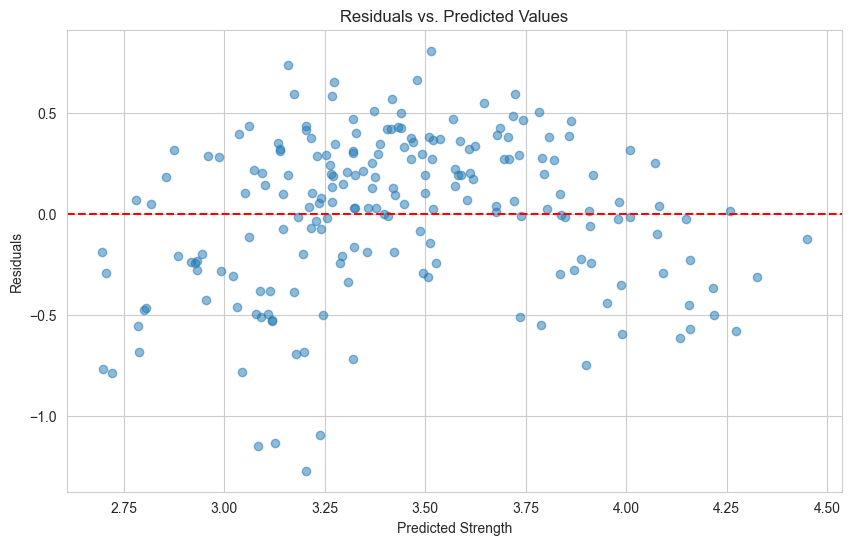

In [101]:
y_pred = model.predict(X_test)

residuals = y_test - y_pred

# Plot residuals against predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predicted Values')
plt.xlabel('Predicted Strength')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


In [102]:
bp_test = het_breuschpagan(residuals, X_test)
pval = bp_test[3]
print(f"Conclusion: {'reject' if pval < 0.05 else 'do not reject null hypothesis of homoskedascity'}")

Conclusion: do not reject null hypothesis of homoskedascity


In [103]:
param_df = model.params.reset_index()
param_df.columns = ['coef', 'value']
param_df

,coef,value
0,const,1.964885
1,cement,0.003190
2,slag,0.002311
3,fly_ash,0.002298
4,superplasticizer,0.022728
5,age,0.003326


## Interpret coefficients of final model

In [105]:
for i, row in param_df.iterrows():
    print(f"A 1-unit increase in {row['coef']} results in a {np.round(100 * (np.exp(row['value']) - 1), 2)}% increase in strength")

A 1-unit increase in const results in a 613.41% increase in strength
A 1-unit increase in cement results in a 0.32% increase in strength
A 1-unit increase in slag results in a 0.23% increase in strength
A 1-unit increase in fly_ash results in a 0.23% increase in strength
A 1-unit increase in superplasticizer results in a 2.3% increase in strength
A 1-unit increase in age results in a 0.33% increase in strength


**Note**: he coefficients for water, coarse_aggregate, and fine_aggregate are all zero